In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

## 모델 평가를 위한 패키지
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config Completer.use_jedi = False

plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rc('axes', unicode_minus=False)


train = pd.read_csv('wine_binary.csv')

# 0 :불량, 1: 정상
def qualityToInt(qualityStr):
    if qualityStr == "bad":
        return 0
    else: 
        return 1

qualityInt = train.quality.apply(qualityToInt)
train.quality = qualityInt
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### 결측치 확인
결측치가 존재하지 않음을 확인

In [23]:
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(dataframe.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')

check_missing_col(train)

결측치가 존재하지 않습니다


## 클래스 분포 확인

각 품질 클래스별 데이터 갯수를 확인하였습니다.

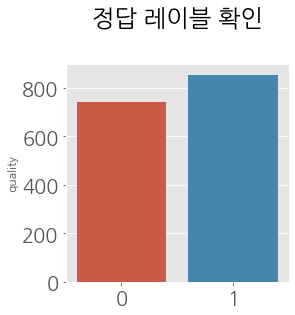

In [35]:
counted_values = train['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(4, 4))
plt.title('정답 레이블 확인', fontsize = 24, pad=40)

value_bar_ax = sns.barplot(x=counted_values.index, y=counted_values)
value_bar_ax.tick_params(labelsize=20)

## 와인 품질마다 고유 특성이 있을까?

각각의 클래스는 어떠한 특성을 갖고있을까요?<br>
와인의 품질별로 feature의 평균값을 시각화하여 특성을 관찰해보겠습니다

In [66]:
qualities = {}

for i in range(0, 2):
    quality_description = train[train['quality'] == i].drop(['quality'], axis=1).describe()
    if i == 0:
        means = pd.DataFrame({i: quality_description.loc['mean']})
    else:
        mean = pd.DataFrame({i: quality_description.loc['mean']})
        means = pd.concat([means, mean], axis=1)
        
means = means.T

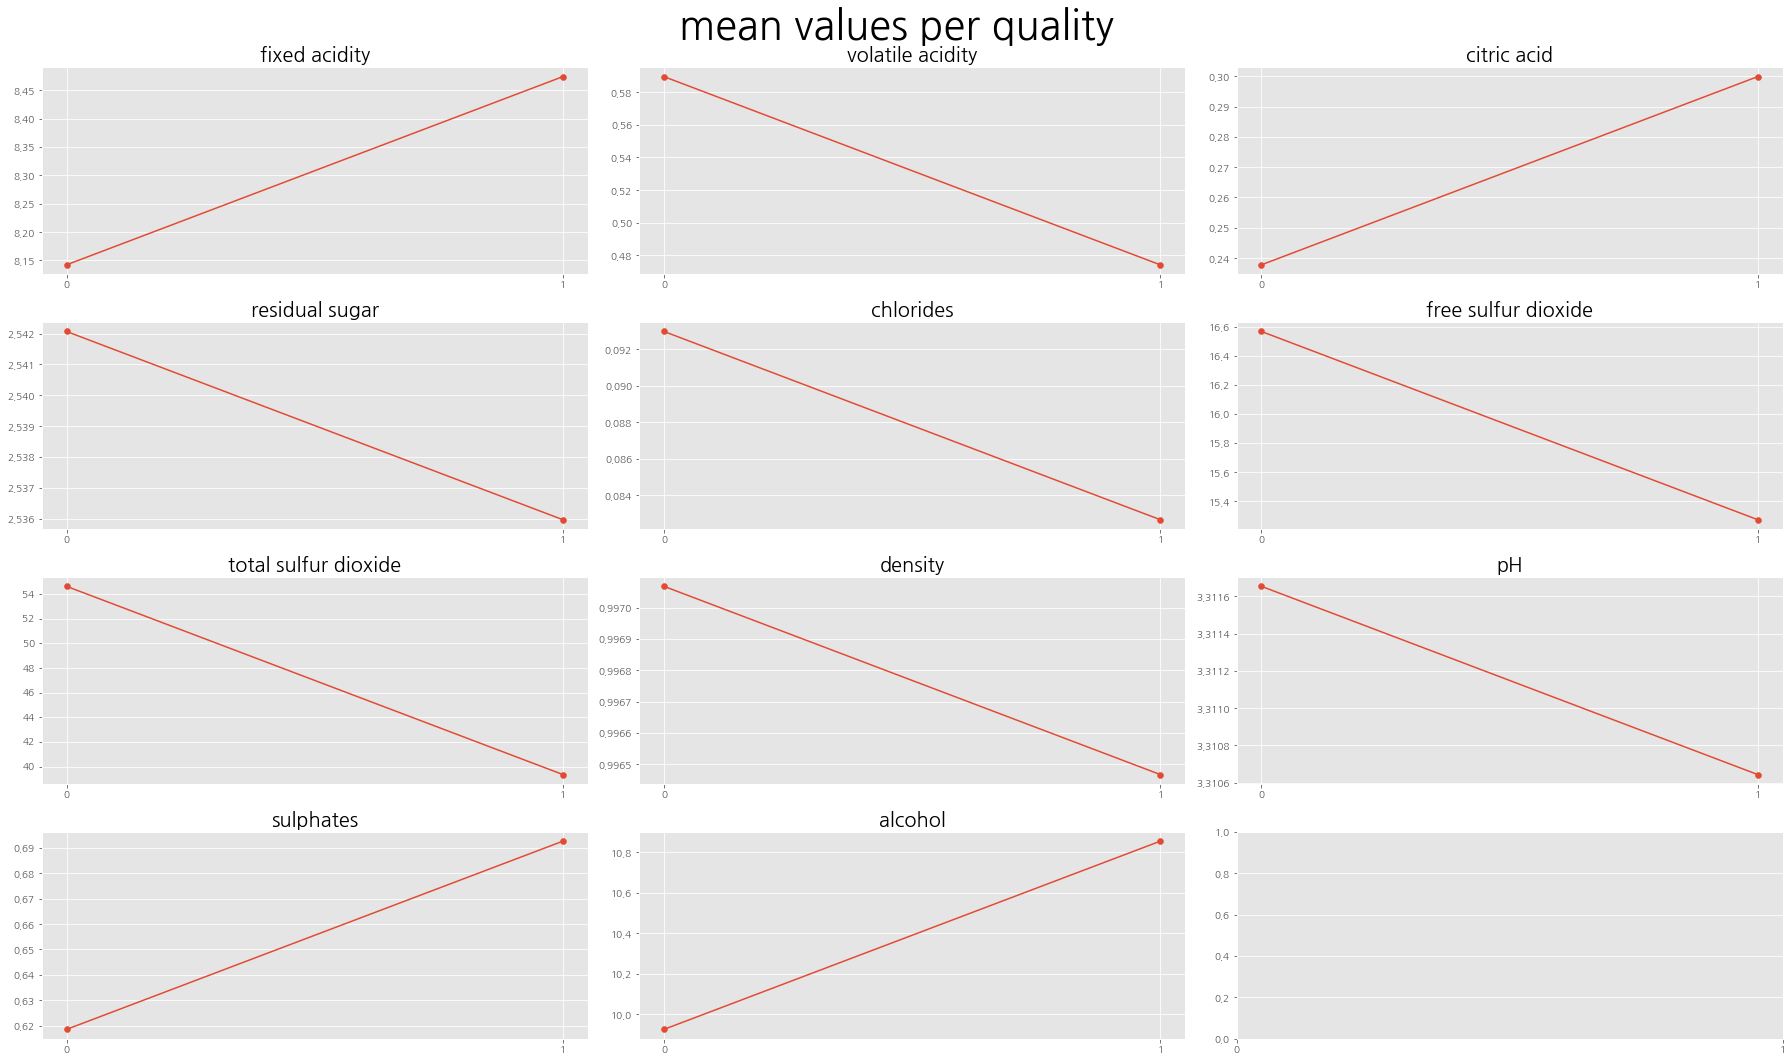

In [70]:
fig, axes = plt.subplots(4, 3, figsize=(25, 15))

fig.suptitle('mean values per quality', fontsize= 40)

for ax, col in zip(axes.flat, means.columns):
    ax.plot([0,1], means[col])
    ax.scatter([0,1], means[col])

    ax.set_title(col, fontsize=20)

plt.setp(axes, xticks=[0,1])
plt.tight_layout()
plt.show()

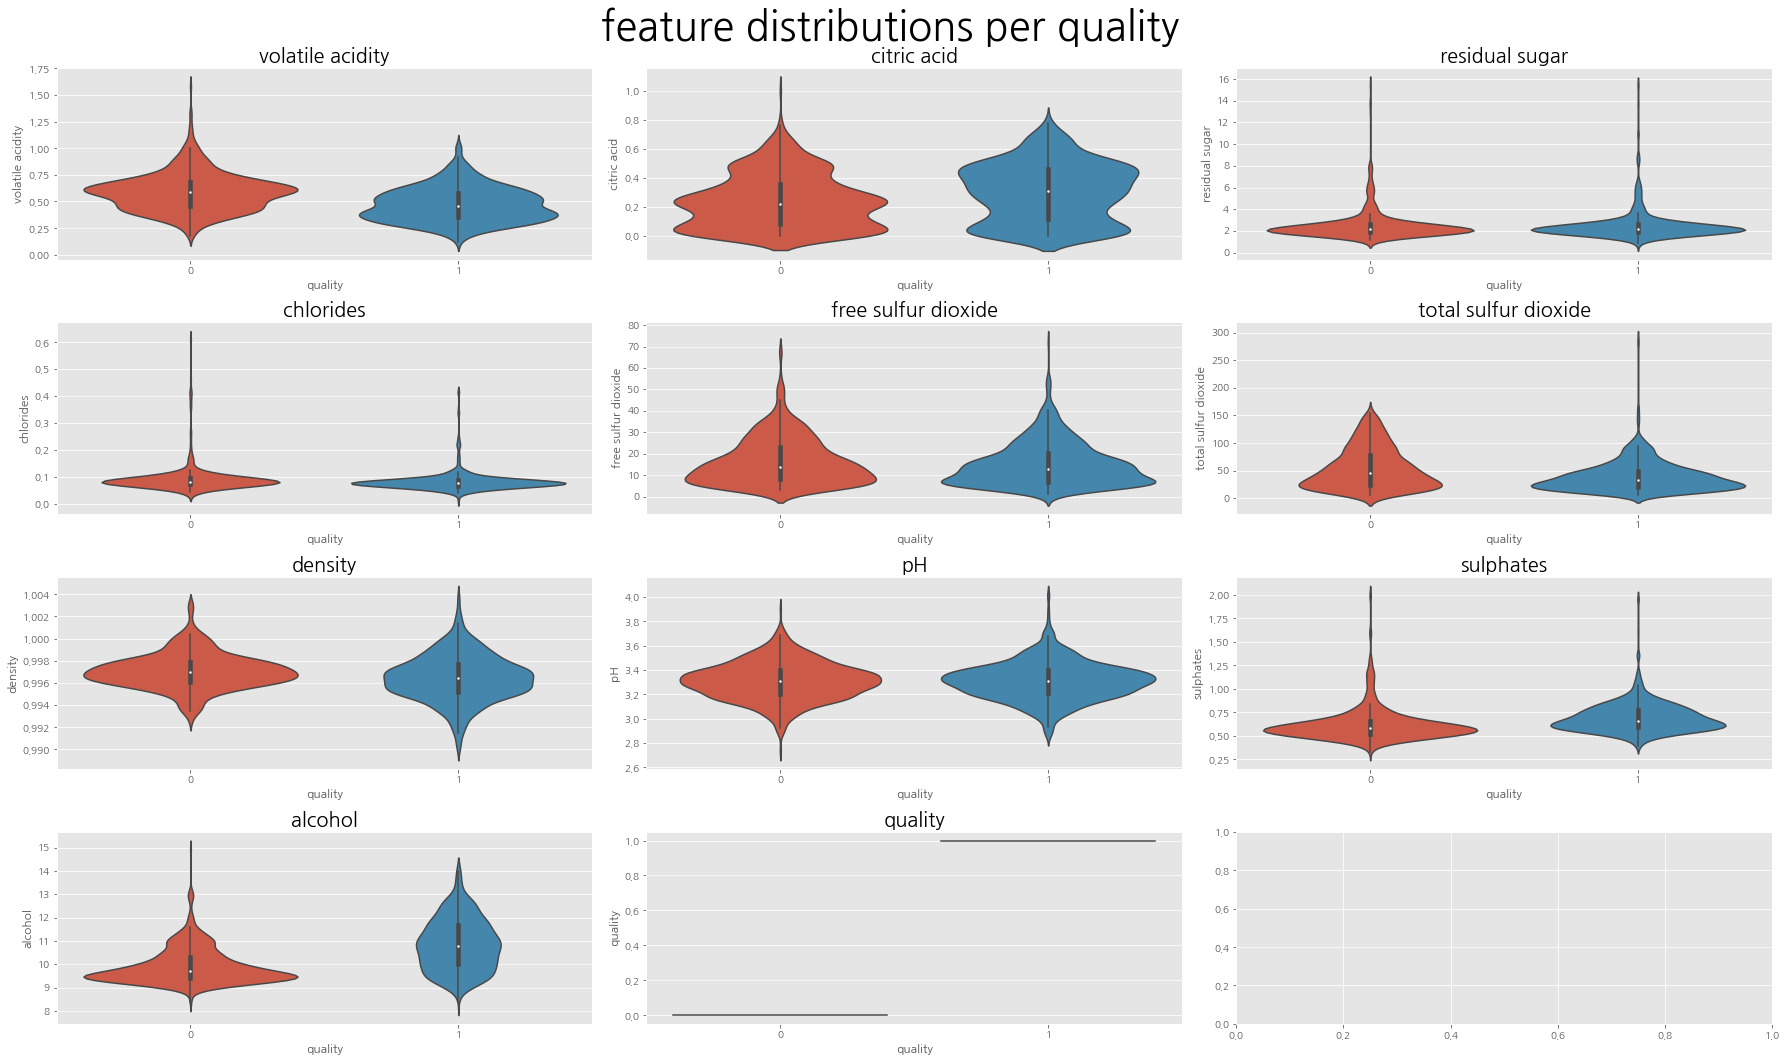

In [71]:
fig, axes = plt.subplots(4, 3, figsize=(25, 15))

fig.suptitle('feature distributions per quality', fontsize= 40)
for ax, col in zip(axes.flat, train.columns[1:]):
    sns.violinplot(x= 'quality', y= col, ax=ax, data=train)
    ax.set_title(col, fontsize=20)
plt.tight_layout()
plt.show()

### 상관관계 분석
Alcohol과 Quality가 양의 상관관계(0.45)를 가지는 것을 알 수 있다.  
Density, VolatileAcidity가 음의 상관관계(각각 -0.31, -0.26)을 가진다

In [77]:
train_data_copy.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

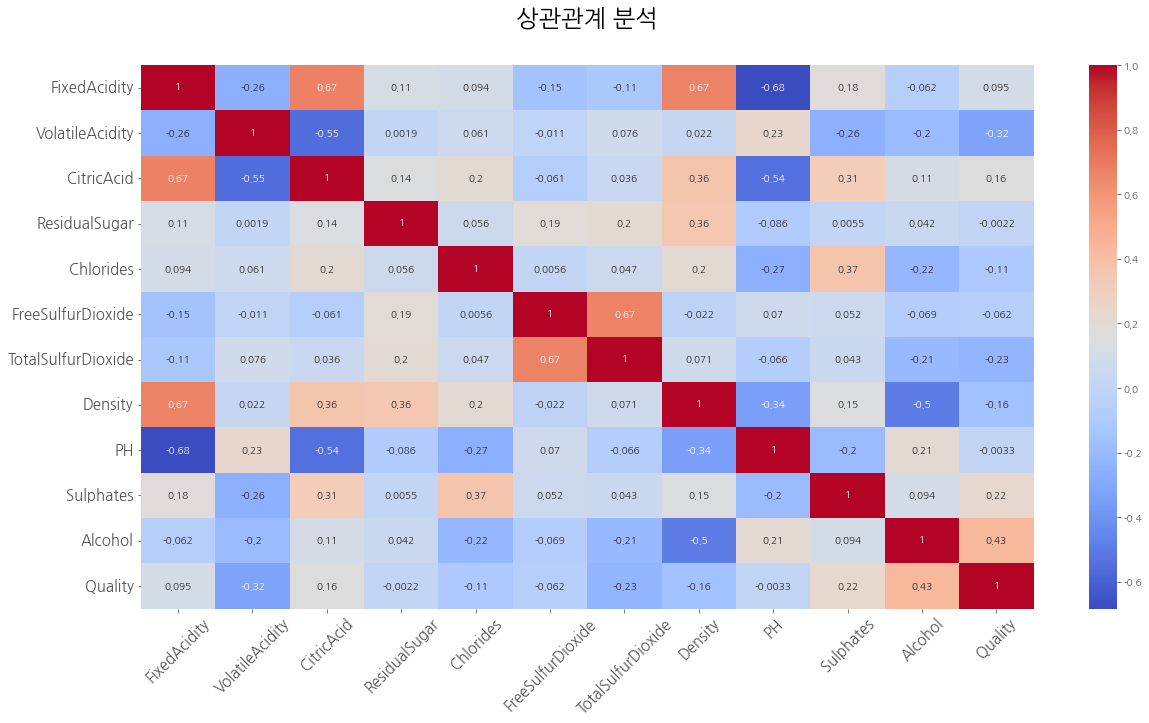

In [102]:
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

train_data_copy = train.copy()
train_data_copy_origin = train.copy()
train_data_copy.quality = train_data_copy.quality
train_data_copy.columns = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide',
       'TotalSulfurDioxide', 'Density', 'PH', 'Sulphates', 'Alcohol',
       'Quality']

# 미사용 컬럼 제거
plt.figure(figsize=(20,10))

heat_table = train_data_copy.corr()
heatmap_ax = sns.heatmap(heat_table, annot=True, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('상관관계 분석', fontsize=24, pad=40)
plt.show()

In [103]:
x = train_data_copy.drop('Quality', axis = 1)
y = train_data_copy['Quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 41)

# 결과 예측

### SVM을 통한 결과 예측

In [104]:
estimator = SVC(kernel='rbf', C=0.5, gamma='auto') 
param_grid = {'kernel':['rbf'], 'C':[1,100,10,0.1,0.01,0.001]}


grid = GridSearchCV(estimator, param_grid=param_grid) 

grid.fit(x_train, y_train)

print(pd.DataFrame(grid.cv_results_).sort_values(by='param_C', ascending=0))
print(grid.best_score_)
print(grid.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
1       0.064059      0.006364         0.017023        0.000368     100   
2       0.047683      0.000737         0.018279        0.000286      10   
0       0.041711      0.004213         0.021278        0.000505       1   
3       0.038256      0.000252         0.023914        0.000099     0.1   
4       0.038328      0.000114         0.023874        0.000132    0.01   
5       0.038360      0.000726         0.023767        0.000182   0.001   

  param_kernel                         params  split0_test_score  \
1          rbf    {'C': 100, 'kernel': 'rbf'}           0.656250   
2          rbf     {'C': 10, 'kernel': 'rbf'}           0.644531   
0          rbf      {'C': 1, 'kernel': 'rbf'}           0.675781   
3          rbf    {'C': 0.1, 'kernel': 'rbf'}           0.542969   
4          rbf   {'C': 0.01, 'kernel': 'rbf'}           0.527344   
5          rbf  {'C': 0.001, 'kernel': 'rbf'}           0.527344  

### 로지스틱 회귀를 통한 예측

test 데이터셋에서 72%의 정확도를 보여주었다.

In [105]:
estimator = LogisticRegression(penalty='l2', C=1.0, max_iter=100, tol=0.0001)

estimator.fit(x_train, y_train)

y_predict = estimator.predict(x_train) 
score = metrics.accuracy_score(y_train, y_predict)
print(score) #1.0

y_predict = estimator.predict(x_test) 
score = metrics.accuracy_score(y_test, y_predict)
print(score) #1.0

0.7474589523064894
0.725


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 최근접 이웃 알고리즘을 통한 예측
test 셋에서 62% 정도의 정확도를 보여주었다.

In [106]:
estimator = KNeighborsClassifier(n_neighbors=5, metric='minkowski', weights='uniform')

estimator.fit(x_train, y_train)

y_predict = estimator.predict(x_train) 
score = metrics.accuracy_score(y_train, y_predict)
print(score) #1.0

y_predict = estimator.predict(x_test) 
score = metrics.accuracy_score(y_test, y_predict)
print(score) #1.0

0.7654417513682564
0.621875


### 의사 결정 나무를 통한 예측
75%정도의 정확도를 보여주었다.

In [107]:
estimator = DecisionTreeClassifier(criterion='gini', max_depth=None, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, max_features=None)

estimator.fit(x_train, y_train)

y_predict = estimator.predict(x_train) 
score = metrics.accuracy_score(y_train, y_predict)
print(score) #1.0

y_predict = estimator.predict(x_test) 
score = metrics.accuracy_score(y_test, y_predict)
print(score) #1.0

1.0
0.765625


### 나이브 베이즈를 통한 예측
test셋에서 71%정도의 정확도를 보여주었다.

In [108]:
estimator = GaussianNB()

estimator.fit(x_train, y_train)

y_predict = estimator.predict(x_train) 
score = metrics.accuracy_score(y_train, y_predict)
print(score) #1.0

y_predict = estimator.predict(x_test) 
score = metrics.accuracy_score(y_test, y_predict)
print(score) #1.0

0.7326035965598123
0.7125


### 앙상블1 기법을 이용한 예측

Test 데이터 셋에서 약 73%의 정확도를 보여주었다.

In [109]:
estimator = VotingClassifier(estimators=[('lr', LogisticRegression()),
                                         ('kn', KNeighborsClassifier()),
                                         ('dt', DecisionTreeClassifier())], voting='hard', weights=None)

estimator.fit(x_train, y_train)

y_predict = estimator.predict(x_train) 
score = metrics.accuracy_score(y_train, y_predict)
print(score) #1.0

y_predict = estimator.predict(x_test) 
score = metrics.accuracy_score(y_test, y_predict)
print(score) #1.0

0.8960125097732604
0.740625


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 랜덤 포레스트 기법을 이용한 예측

Test 데이터 셋에서 약 82%의 정확도를 보여주었다

In [110]:
estimator = RandomForestClassifier()
# estimator = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

estimator.fit(x_train, y_train)

y_predict = estimator.predict(x_train) 
score = metrics.accuracy_score(y_train, y_predict)
print(score) #1.0

y_predict = estimator.predict(x_test) 
score = metrics.accuracy_score(y_test, y_predict)
print(score) #1.0

1.0
0.83125


### MLP를 통한 예측

In [136]:
import tensorflow as tf
from keras.layers import Dense , Dropout, Activation
from tensorflow import keras
from tensorflow.keras import layers


def get_compiled_model():
    model = tf.keras.Sequential([
        Dense(30, input_dim=11, activation='relu'),
        Dropout(0.2),
        Dense(12, activation='relu'),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    sgd = keras.optimizers.SGD(lr = 0.001)
    model.compile(optimizer=sgd,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_compiled_model()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_batch_dataset = train_dataset.shuffle(len(x_train)).batch(1)

history = model.fit(train_batch_dataset, epochs=100)

Epoch 1/100
1279/1279 [==============================] - 1s 626us/step - loss: 0.7310 - accuracy: 0.5121
Epoch 2/100
1279/1279 [==============================] - 1s 627us/step - loss: 0.6964 - accuracy: 0.5379
Epoch 3/100
1279/1279 [==============================] - 1s 622us/step - loss: 0.6895 - accuracy: 0.5215
Epoch 4/100
1279/1279 [==============================] - 1s 702us/step - loss: 0.6855 - accuracy: 0.5512
Epoch 5/100
1279/1279 [==============================] - 1s 658us/step - loss: 0.6869 - accuracy: 0.5653
Epoch 6/100
1279/1279 [==============================] - 1s 637us/step - loss: 0.6898 - accuracy: 0.5403
Epoch 7/100
1279/1279 [==============================] - 1s 639us/step - loss: 0.6845 - accuracy: 0.5645
Epoch 8/100
1279/1279 [==============================] - 1s 625us/step - loss: 0.6837 - accuracy: 0.5575
Epoch 9/100
1279/1279 [==============================] - 1s 648us/step - loss: 0.6854 - accuracy: 0.5637
Epoch 10/100
1279/1279 [==============================]

1279/1279 [==============================] - 1s 731us/step - loss: 0.6485 - accuracy: 0.6177
Epoch 79/100
1279/1279 [==============================] - 1s 947us/step - loss: 0.6463 - accuracy: 0.6239
Epoch 80/100
1279/1279 [==============================] - 1s 822us/step - loss: 0.6556 - accuracy: 0.6185
Epoch 81/100
1279/1279 [==============================] - 1s 723us/step - loss: 0.6512 - accuracy: 0.6247
Epoch 82/100
1279/1279 [==============================] - 1s 608us/step - loss: 0.6504 - accuracy: 0.6224
Epoch 83/100
1279/1279 [==============================] - 1s 605us/step - loss: 0.6508 - accuracy: 0.6216
Epoch 84/100
1279/1279 [==============================] - 1s 611us/step - loss: 0.6516 - accuracy: 0.6208
Epoch 85/100
1279/1279 [==============================] - 1s 613us/step - loss: 0.6497 - accuracy: 0.6200
Epoch 86/100
1279/1279 [==============================] - 1s 628us/step - loss: 0.6561 - accuracy: 0.6083
Epoch 87/100
1279/1279 [==============================] - 1

In [119]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values))
test_batch_dataset = test_dataset.shuffle(len(x_test)).batch(1)
_, accuracy = model.evaluate(test_batch_dataset)

print("MLP를 통한 정확도 = {}%".format(round(accuracy * 100,1)))

320/320 [==============================] - 0s 572us/step - loss: 0.5826 - accuracy: 0.6844
MLP를 통한 정확도 = 68.4%
